In [24]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import altair as alt
from Utilities import Utils

In [158]:
byage = pd.read_csv("data\\USCS-1999-2018-ASCII\\BYAGE.TXT", sep="|", low_memory=False)
by_county = pd.read_csv("data\\USCS-1999-2018-ASCII\\BYAREA_COUNTY.TXT", sep="|", low_memory=False)
counties =  gpd.read_file("data\\2020_us_county_shp\\cb_2020_us_county_20m.shp")

geo = counties[counties["STUSPS"] == "NJ"]

In [36]:
byarea = pd.read_csv("data\\USCS-1999-2018-ASCII\\BYAREA.TXT", sep="|", low_memory=False)
byarea = byarea[['AREA', 'AGE_ADJUSTED_RATE','EVENT_TYPE', 'RACE', 'SEX', 'SITE', 'YEAR']]
byarea = byarea[byarea["YEAR"] != '2014-2018']
byarea = byarea[byarea["RACE"] == "All Races"]
byarea = byarea.astype({'YEAR': 'int', 'AREA':'object'})
byarea = byarea[(byarea["SITE"] == "All Cancer Sites Combined") & (byarea["SEX"] == "Male and Female")]
byarea = Utils.remove_rows(byarea, ['~', '+', '.', '-'])
byarea = Utils.get_mir(byarea, ['AREA', 'RACE', 'SEX', 'SITE', 'YEAR'], 'AGE_ADJUSTED_RATE')
byarea = byarea[["AREA","YEAR","MIR"]]
byarea = byarea.sort_values(['YEAR'])

In [70]:
grouped = byarea.groupby(by="AREA")

In [28]:
state_change = (grouped['MIR'].last() - grouped['MIR'].first())/grouped['MIR'].first()

In [29]:
print("Worst Improvement: " + str(state_change.idxmax()) + " " + str(state_change.max()))
print("Best improvement: " + str(state_change.idxmin()) + " " + str(state_change.min()))

Worst Improvement: New Mexico -0.02892027050256729
Best improvement: Tennessee -0.3241981863975525


In [100]:
states = byarea["AREA"].unique()
states.sort()
state_dropdown = alt.binding_select(options=states)
state_select = alt.selection_single(fields=['AREA'], bind=state_dropdown, name="State")
state_color_condition = alt.condition(state_select, alt.Color('AREA:N', legend=None), alt.value('lightgray'))
background_chart = alt.Chart(byarea).mark_line().encode(
    x=alt.X("YEAR", scale=alt.Scale(domain=[1999,2018])),
    y=alt.Y('MIR', scale=alt.Scale(domain=[0.275, 0.55])),
    detail="AREA",
    tooltip="AREA",
    color = alt.value("lightgray")
)

selected_state = alt.Chart(byarea).mark_line().encode(
    x=alt.X("YEAR", scale=alt.Scale(domain=[1999,2018])),
    y=alt.Y('MIR', scale=alt.Scale(domain=[0.275, 0.55])),
    detail="AREA",
    tooltip="AREA",
    color="AREA"
).add_selection(
    state_select
).transform_filter(
    state_select
)

background_chart + selected_state

alt.LayerChart(...)

In [33]:
by_county = Utils.remove_rows(by_county, ["~","+","-","~"])
by_county.loc[:, "AREA"] = by_county.loc[:, "AREA"].apply(Utils._strip_county_name)

AttributeError: type object 'Utils' has no attribute '_strip_county_name'

<AxesSubplot:>

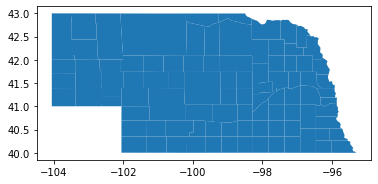

In [ ]:
geo[geo["STUSPS"] == "NE"].plot()

In [162]:
counties

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,05,121,00069178,0500000US05121,05121,Randolph,Randolph County,AR,Arkansas,06,1688445990,10370823,"POLYGON ((-91.40492 36.49712, -91.12654 36.497..."
1,08,069,00198150,0500000US08069,08069,Larimer,Larimer County,CO,Colorado,06,6723014102,98984559,"POLYGON ((-106.19055 40.99775, -105.27714 40.9..."
2,26,105,01622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,06,1281963206,1935616622,"POLYGON ((-86.51470 44.05812, -86.45807 44.099..."
3,28,153,00695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,06,2099745602,7255476,"POLYGON ((-88.94335 31.82456, -88.91046 31.826..."
4,38,075,01034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,06,2272050275,40658499,"POLYGON ((-102.02164 48.80711, -102.02122 48.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,077,00394951,0500000US16077,16077,Power,Power County,ID,Idaho,06,3635892401,99205466,"POLYGON ((-113.24348 43.11095, -113.00771 43.1..."
3217,46,085,01265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,06,4253498542,167300393,"POLYGON ((-100.36725 44.19462, -99.93822 44.19..."
3218,55,115,01581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,06,2313441749,41883059,"POLYGON ((-89.22381 45.02925, -88.98168 45.028..."
3219,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,"POLYGON ((-117.03554 46.41001, -117.03665 46.4..."


In [163]:
conds_for_by_county = (by_county["STATE"] != "AK") & \
                        (by_county["STATE"] != "HI") # & \
                        # (by_county["RACE"].notna())
states_for_counties = (counties["STUSPS"] != "AK") & \
                        (counties["STUSPS"] != "HI")
by_county = by_county[conds_for_by_county]
counties = counties[states_for_counties]

by_county_c = by_county[["AREA", "RACE", "SITE", "YEAR", "EVENT_TYPE",
                            "AGE_ADJUSTED_RATE", "SEX", "STATE"]].copy()
print(len(by_county[by_county_c["RACE"].isnull()]))
counties_c = counties[["GEOID", "NAMELSAD", "STUSPS", "STATE_NAME",
                        "geometry"]].copy()
by_county_c = by_county_c[(by_county_c["SITE"] == "All Cancer Sites Combined") & (by_county_c["SEX"] == "Male and Female")]
by_county_c = Utils.remove_rows(data=by_county_c,
                                chars=['+', '~', '.', '-'])
by_county_c = Utils.get_mir(data=by_county_c, 
                            on=['AREA', 'RACE', 'SEX', 'SITE', 'YEAR'],
                            rate_col='AGE_ADJUSTED_RATE')
races = [str(race) for race in by_county["RACE"].unique()]
prepared_shp, states_shp = Utils._clean_join_shp(by_county_c, counties_c)

# races = prepared_shp["RACE"] == "All Races"
# sites = prepared_shp["SITE"] == "All Cancer Sites Combined"
# sexes = prepared_shp["SEX"] == "Male and Female"
# prepared_shp = prepared_shp[races & sites & sexes]

0


In [164]:
print(by_county_c.shape)
print(counties_c.shape)
print(prepared_shp.shape)

(8042, 13)
(3186, 5)
(8374, 18)


In [166]:
alt.data_transformers.disable_max_rows()
scale = alt.Scale(domain=[0.10, 1.12])

race_dropdown = alt.binding_select(options = races)
race_select = alt.selection_single(fields = ["RACE"], bind=race_dropdown, init={"RACE":races[0]})

background = alt.Chart(states_shp) \
                .mark_geoshape(fill="lightgray", stroke="white")

mir_highlight = alt.Chart(prepared_shp).mark_geoshape().encode(
    color=alt.Color("MIR:Q", scale=scale)
).add_selection(
    race_select
).transform_filter(
    race_select
)

(background + mir_highlight).save("interactive_test.html")


In [165]:
prepared_shp

,GEOID,NAMELSAD,STUSPS,STATE_NAME,geometry,AREA,RACE,SITE,YEAR,EVENT_TYPE_x,AGE_ADJUSTED_RATE_x,SEX,STATE_x,EVENT_TYPE_y,AGE_ADJUSTED_RATE_y,STATE_y,MIR,geoid
0,5121.0,Randolph County,AR,Arkansas,"POLYGON ((-91.40492 36.49712, -91.12654 36.497...",AR: Randolph County (05121),All Races,All Cancer Sites Combined,2014-2018,Mortality,202.699997,Male and Female,AR,Incidence,539.000000,AR,0.376067,5121.0
1,5121.0,Randolph County,AR,Arkansas,"POLYGON ((-91.40492 36.49712, -91.12654 36.497...",AR: Randolph County (05121),White,All Cancer Sites Combined,2014-2018,Mortality,206.199997,Male and Female,AR,Incidence,544.799988,AR,0.378488,5121.0
2,8069.0,Larimer County,CO,Colorado,"POLYGON ((-106.19055 40.99775, -105.27714 40.9...",CO: Larimer County (08069),All Races,All Cancer Sites Combined,2014-2018,Mortality,130.800003,Male and Female,CO,Incidence,414.600006,CO,0.315485,8069.0
3,8069.0,Larimer County,CO,Colorado,"POLYGON ((-106.19055 40.99775, -105.27714 40.9...",CO: Larimer County (08069),Hispanic,All Cancer Sites Combined,2014-2018,Mortality,127.599998,Male and Female,CO,Incidence,400.299988,CO,0.318761,8069.0
4,8069.0,Larimer County,CO,Colorado,"POLYGON ((-106.19055 40.99775, -105.27714 40.9...",CO: Larimer County (08069),White,All Cancer Sites Combined,2014-2018,Mortality,132.399994,Male and Female,CO,Incidence,417.200012,CO,0.317354,8069.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8369,16069.0,Nez Perce County,ID,Idaho,"POLYGON ((-117.03554 46.41001, -117.03665 46.4...",ID: Nez Perce County (16069),All Races,All Cancer Sites Combined,2014-2018,Mortality,181.600006,Male and Female,ID,Incidence,446.200012,ID,0.406992,16069.0
8370,16069.0,Nez Perce County,ID,Idaho,"POLYGON ((-117.03554 46.41001, -117.03665 46.4...",ID: Nez Perce County (16069),American Indian/Alaska Native,All Cancer Sites Combined,2014-2018,Mortality,190.300003,Male and Female,ID,Incidence,444.500000,ID,0.428121,16069.0
8371,16069.0,Nez Perce County,ID,Idaho,"POLYGON ((-117.03554 46.41001, -117.03665 46.4...",ID: Nez Perce County (16069),White,All Cancer Sites Combined,2014-2018,Mortality,180.800003,Male and Female,ID,Incidence,444.299988,ID,0.406932,16069.0
8372,46029.0,Codington County,SD,South Dakota,"POLYGON ((-97.49425 45.15163, -97.24913 45.151...",SD: Codington County (46029),All Races,All Cancer Sites Combined,2014-2018,Mortality,167.800003,Male and Female,SD,Incidence,466.399994,SD,0.359777,46029.0


,GEOID,NAMELSAD,STUSPS,STATE_NAME,geometry,AREA,RACE,SITE,YEAR,EVENT_TYPE_x,AGE_ADJUSTED_RATE_x,SEX,STATE_x,EVENT_TYPE_y,AGE_ADJUSTED_RATE_y,STATE_y,MIR,geoid
36,34013.0,Essex County,NJ,New Jersey,"POLYGON ((-74.36714 40.76111, -74.32611 40.908...",NJ: Essex County (34013),All Races,All Cancer Sites Combined,2014-2018,Mortality,148.300003,Male and Female,NJ,Incidence,462.600006,NJ,0.320579,34013.0
62,34013.0,Essex County,NJ,New Jersey,"POLYGON ((-74.36714 40.76111, -74.32611 40.908...",NJ: Essex County (34013),Asian/Pacific Islander,All Cancer Sites Combined,2014-2018,Mortality,71.500000,Male and Female,NJ,Incidence,305.100006,NJ,0.234349,34013.0
97,34013.0,Essex County,NJ,New Jersey,"POLYGON ((-74.36714 40.76111, -74.32611 40.908...",NJ: Essex County (34013),Black,All Cancer Sites Combined,2014-2018,Mortality,173.000000,Male and Female,NJ,Incidence,439.799988,NJ,0.393361,34013.0
129,34013.0,Essex County,NJ,New Jersey,"POLYGON ((-74.36714 40.76111, -74.32611 40.908...",NJ: Essex County (34013),Hispanic,All Cancer Sites Combined,2014-2018,Mortality,103.099998,Male and Female,NJ,Incidence,414.600006,NJ,0.248673,34013.0
174,34013.0,Essex County,NJ,New Jersey,"POLYGON ((-74.36714 40.76111, -74.32611 40.908...",NJ: Essex County (34013),White,All Cancer Sites Combined,2014-2018,Mortality,138.399994,Male and Female,NJ,Incidence,471.100006,NJ,0.293781,34013.0


In [109]:

background = alt.Chart(states_shp) \
                .mark_geoshape(fill="lightgray", stroke="white")

race_dropdown = alt.binding_select(options=races, name="Race")
race_select = alt.selection_single(bind=race_dropdown,
                                    fields=["Race", "geometry"])

mir_highlight = alt.Chart(prepared_shp) \
    .mark_geoshape() \
    .encode(color = alt.Color("MIR:Q", scale=scale)) \
    .add_selection(race_select) \
    .transform_filter(race_select) \
    .properties(title="Mortality Incidence Rate for US counties (2014-2018)")

(background + mir_highlight).save("interactive_test.html")

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
41,34,013,00882276,0500000US34013,34013,Essex,Essex County,NJ,New Jersey,06,326557433,8638155,"POLYGON ((-74.36714 40.76111, -74.32611 40.908..."
435,34,001,00882270,0500000US34001,34001,Atlantic,Atlantic County,NJ,New Jersey,06,1438774368,301270979,"POLYGON ((-74.91188 39.57846, -74.87726 39.608..."
559,34,029,00882279,0500000US34029,34029,Ocean,Ocean County,NJ,New Jersey,06,1627252596,742162038,"POLYGON ((-74.55311 40.07913, -74.40671 40.172..."
601,34,027,00882231,0500000US34027,34027,Morris,Morris County,NJ,New Jersey,06,1193911893,53230151,"POLYGON ((-74.85051 40.80396, -74.76942 40.910..."
1202,34,009,00882274,0500000US34009,34009,Cape May,Cape May County,NJ,New Jersey,06,651437935,955149083,"POLYGON ((-74.95536 39.00126, -74.90366 39.087..."
1343,34,011,00882275,0500000US34011,34011,Cumberland,Cumberland County,NJ,New Jersey,06,1251898249,503713126,"POLYGON ((-75.41711 39.38891, -75.36821 39.456..."
1544,34,021,00882229,0500000US34021,34021,Mercer,Mercer County,NJ,New Jersey,06,581297767,11434809,"POLYGON ((-74.92811 40.33983, -74.85626 40.346..."
1602,34,015,00882277,0500000US34015,34015,Gloucester,Gloucester County,NJ,New Jersey,06,833976887,38259771,"POLYGON ((-75.41049 39.80467, -75.34176 39.846..."
1658,34,039,00882235,0500000US34039,34039,Union,Union County,NJ,New Jersey,06,266163567,6847407,"POLYGON ((-74.46329 40.59919, -74.42440 40.619..."
1718,34,007,00882273,0500000US34007,34007,Camden,Camden County,NJ,New Jersey,06,573315345,15699106,"POLYGON ((-75.13342 39.89621, -75.13459 39.922..."


In [132]:
by_county

,STATE,AREA,AGE_ADJUSTED_CI_LOWER,AGE_ADJUSTED_CI_UPPER,AGE_ADJUSTED_RATE,COUNT,EVENT_TYPE,POPULATION,RACE,SEX,SITE,YEAR,CRUDE_CI_LOWER,CRUDE_CI_UPPER,CRUDE_RATE
28416,AL,AL: Autauga County (01001),399.1,463.4,430.3,727,Incidence,141421,All Races,Female,All Cancer Sites Combined,2014-2018,477.4,552.8,514.1
28417,AL,AL: Autauga County (01001),119.2,154.9,136.1,238,Mortality,141421,All Races,Female,All Cancer Sites Combined,2014-2018,147.6,191.1,168.3
28418,AL,AL: Autauga County (01001),~,~,~,~,Incidence,141421,All Races,Female,Brain and Other Nervous System,2014-2018,~,~,~
28419,AL,AL: Autauga County (01001),~,~,~,~,Mortality,141421,All Races,Female,Brain and Other Nervous System,2014-2018,~,~,~
28420,AL,AL: Autauga County (01001),~,~,~,~,Incidence,141421,All Races,Female,Cervix,2014-2018,~,~,~
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718055,WY,WY: Weston County (56045),~,~,~,~,Mortality,17864,White,Male and Female,Testis,2014-2018,~,~,~
2718056,WY,WY: Weston County (56045),~,~,~,~,Incidence,33965,White,Male and Female,Thyroid,2014-2018,~,~,~
2718057,WY,WY: Weston County (56045),~,~,~,~,Mortality,33965,White,Male and Female,Thyroid,2014-2018,~,~,~
2718058,WY,WY: Weston County (56045),~,~,~,~,Incidence,33965,White,Male and Female,Urinary Bladder,2014-2018,~,~,~
